In [ ]:
"""
a script to download, filter, preprocess, and partition the raw data into training and test splits
"""



In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import SimpleITK as sitk
import json
import os

In [4]:
def read_image(ct_path):
    if os.path.exists(ct_path):
        itkimage = sitk.ReadImage(ct_path)
        ct_scan = sitk.GetArrayFromImage(itkimage)
        origin = np.array(list(reversed(itkimage.GetOrigin())))
        spacing = np.array(list(reversed(itkimage.GetSpacing())))
        direction = np.array(list(reversed(itkimage.GetDirection())))
        return ct_scan, origin, spacing, direction
    else:
        print("The file path doesn't exist")
ct_path = '/Users/aibotasanatbek/Documents/calcium_scoring/data/raw/3/TRV1P3CTI.nii'
ct_scan, origin, spacing, direction = read_image(ct_path)
print(ct_scan.shape)
print(origin)
print(spacing)
print(direction.reshape(3,3))

(56, 512, 512)
[0. 0. 0.]
[2.5        0.48828101 0.48828101]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


In [5]:
def plot_scan(ct_scan, n=5, window=500, level=100):
  #visualizing the first n*n images of the given patient data
  fig, ax = plt.subplots(n, n, figsize=(10, 10))
  if n*n < ct_scan.shape[0]:
    for i in range(n*n):
      row = i // n
      col = i % n
      vmin = level - window/2
      vmax = level + window/2
      ax[row,col].imshow(ct_scan[i], cmap=plt.cm.gray, vmin=vmin, vmax=vmax)
      ax[row,col].axis('off')
    plt.show()
  else: 
    print("n out of range. Please enter smaller")

plot_scan(ct_scan)

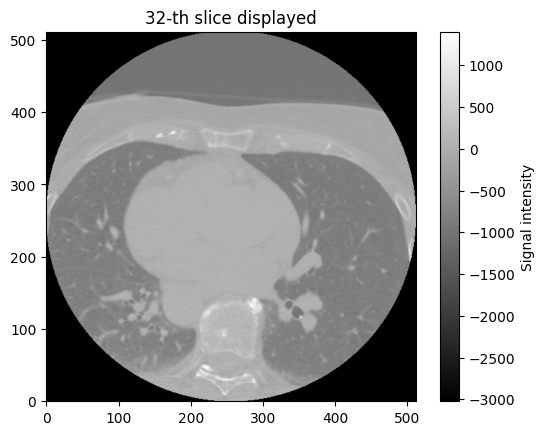

In [ ]:
def plot_single_slice(ct_scan, n=32):
  """
  plots n-th slice of a scan
  """
  plt.imshow(np.rot90(ct_scan[n], k=2), cmap=plt.cm.gray, origin="lower")
  plt.title(f'{n}-th slice displayed')
  plt.colorbar(label='Signal intensity')
  plt.show()  

plot_single_slice(ct_scan)

In [ ]:
#get 3D bounding box coordinates from json file
def read_from_json(json_path):
    if os.path.exists(json_path):
        with open(label_path) as f:
            label_json = json.load(f)
            x, y, z = label_json['markups'][0]['center']
            length, width, height = label_json['markups'][0]['size']
            orientation = np.array(label_json['markups'][0]['orientation'])
            center, dimension = [x,y,z], [length, width, height]
            return center, dimension, orientation
    else:
        print(f"The file '{json_path}' does not exist.")

label_path = '/Users/aibotasanatbek/Documents/calcium_scoring/data/raw/3/bifurcation.json'
center, dimension, orientation = read_from_json(label_path)
print(orientation.reshape(3,3))

[[-1. -0. -0.]
 [-0. -1. -0.]
 [ 0.  0.  1.]]


In [207]:
def get_3Dbox_coordinates(ct_path, json_path):
    center, dimension, orientation = read_from_json(json_path)
    ct_scan, origin, spacing, direction = read_image(ct_path)
    x_center = center[0] / spacing[1]
    y_center = center[1] / spacing[2]
    z_center = center[2] / spacing[0]
    center_coordinates = [x_center, y_center, z_center]
    return ct_scan, center_coordinates, dimension



In [209]:
def generate_yolo_labels(ct_path, json_path):
    ct_scan, [x,y,z], [l,w,h] = get_3Dbox_coordinates(ct_path, json_path)
    # calculate bounding box coordinates respective to the image
    x_norm = x / ct_scan.shape[1]
    y_norm = y / ct_scan.shape[2]
    # get z slice indexes that contain bounding boxes
    # slice_idxs = [int(idx) for idx in range(int(z - l), int(z + l) + 1)]
    # if slice is in the slice_idxs list, then write the labels to text and save in path otherwise write empty txt file (no bifurcation)
    return x_norm, y_norm, w, h

In [200]:
def plot_bbox_patches(ct_scan, center_coordinates, dimension):
    length, width, height = dimension
    x_min, y_min = center_coordinates[0] - width/2, center_coordinates[1] - height/2
    slice_idxs = [int(idx) for idx in range(int(center_coordinates[2]-length), int(center_coordinates[2]+length) + 1)]
    if len(slice_idxs) >= 3:
        fig, ax = plt.subplots(1, 3, figsize=(15, 5))
        for i in range(3):
            slice_image = ct_scan[slice_idxs[i], :, :]
            ax[i].imshow(slice_image, cmap='gray')
            ax[i].set_title(f"Slice {slice_idxs[i]}")
            rect = plt.Rectangle((x_min, y_min), width, height, fill=False, edgecolor='red', linewidth=2)
            ax[i].add_patch(rect)
        plt.show()

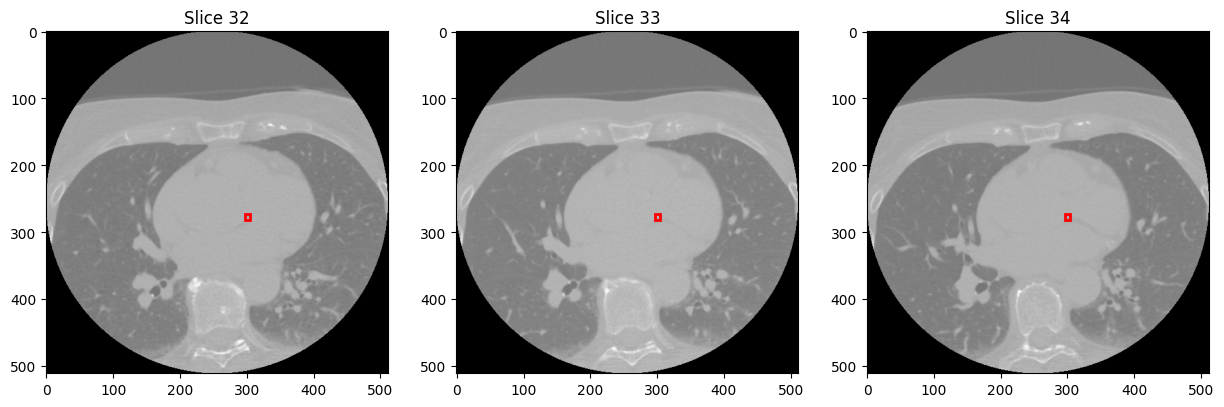

(0.5869742856319754, 0.5407081497598387, 7.346364512383218, 9.047961255810506)

In [206]:
label_path = '/Users/aibotasanatbek/Documents/calcium_scoring/data/raw/3/bifurcation.json'
ct_scan, center_coordinates, dimension = get_3Dbox_coordinates(ct_path, label_path)
plot_bbox_patches(ct_scan, center_coordinates, dimension)

generate_yolo_labels(ct_path, label_path)

In [2]:
def normalize(ct_scan):
    scan = (ct_scan - np.mean(ct_scan)) / np.std(ct_scan)
    return scan

plot_single_slice(normalize(ct_scan))

NameError: name 'plot_single_slice' is not defined

In [ ]:
def resample():
    